# Compositing

## Goal

The goal of this experiment is to find the optimal number of composites per year for each compositing method. We choose from a selection of compositing methods offered by the Earth Engine API, called [ImageCollection Reductions](https://developers.google.com/earth-engine/guides/reducers_image_collection).

## Experiment

The experiment is conducted as follows:

- A time window of 1 year is used, starting with April 1st, 2017.
- We try 1 to 12 composites for each compositing method.
- Only the optimal bands determined in the previous experiment are used.
- Random Forest from scikit-learn with default parameters is chosen as the regression model.
- RMSE with 5-fold cross validation will be used for determining the optimal number of composites.

We start by listing all available reducers:

In [1]:
# List the available reducers
from ltm.data import list_reducers

reducers = list_reducers()

print("ImageCollection Reductions:", reducers)

ImageCollection Reductions: ['And', 'Or', 'allNonZero', 'anyNonZero', 'bitwiseAnd', 'bitwiseOr', 'circularMean', 'circularStddev', 'circularVariance', 'count', 'countDistinct', 'countDistinctNonNull', 'countRuns', 'first', 'firstNonNull', 'kendallsCorrelation', 'kurtosis', 'last', 'lastNonNull', 'max', 'mean', 'median', 'min', 'minMax', 'mode', 'product', 'sampleStdDev', 'sampleVariance', 'skew', 'stdDev', 'sum', 'variance']


The reducers are divided into groups based on their functionality to select the most appropriate reducers for our problem. The groups are as follows:

| Grouping Criterion                 | Reducers                                                      |
| ---------------------------------- | ------------------------------------------------------------- |
| Non-zero based                     | `And` `Or` `allNonZero` `anyNonZero`                          |
| Bitwise                            | `bitwiseAnd` `bitwiseOr`                                      |
| Descriptive statistics (radians)   | `circularMean` `circularStddev` `circularVariance`            |
| Non-null based                     | `count`                                                       |
| Value count based                  | `countDistinct` `countDistinctNonNull` `countRuns`            |
| Single image                       | `first` `firstNonNull` `last` `lastNonNull`                   |
| Correlation                        | `kendallsCorrelation`                                         |
| Descriptive statistics             | `kurtosis` `max` `mean` `median` `min` `minMax` `mode` `skew` |
| Arithmetic result                  | `product` `sum`                                               |
| Descriptive statistics (deviation) | `sampleStdDev` `sampleVariance` `stdDev` `variance`           |

We will continue with only select descriptive statistics, incluiding deviation based reducers and the correlation reducer. The reasoning is explained in detail in our paper. Following reducers are selected:

In [2]:
reducers = [
    "kendallsCorrelation",
    "kurtosis",
    "max",
    "mean",
    "median",
    "min",
    "mode",
    "sampleStdDev",
    "skew",
]

Following Sentinel 2 bands and indices were determined in the previous experiment and are thus used in this experiment:

In [3]:
# List the bands determined by the previous experiment
from ltm.models import bands_from_importance

sentinel_bands, indices = bands_from_importance("../reports/band_importance.csv")

print("Level-2A bands:", sentinel_bands)
print("Indices:", indices)

Initializing Earth Engine API...
Level-2A bands: ['B9', 'WVP', 'TCI_G']
Indices: ['BAIM', 'BWDRVI', 'GCC', 'MCARI705', 'MIRBI', 'MLSWI26', 'MNLI', 'MTCI', 'MuWIR', 'NBRplus', 'NDDI', 'NDGI', 'NSDSI1', 'NormR', 'RGRI', 'S2WI', 'SIPI', 'TRRVI', 'TTVI', 'VI700', 'VIBI', 'WI2', 'WI2015', 'kEVI', 'kIPVI', 'kNDVI', 'mSR705']


We now compute all possible combinations of compositing method and number of composites with the Earth Engine API. The resulting rasters are used to train a Random Forest model with 5-fold cross validation each. The RMSEs are used to determine the optimal number of composites for each compositing method.

In [4]:
# Perform a grid exploration over all reducers and number of composites
from datetime import datetime
from itertools import product
from ltm.data import sentinel_composite
from ltm.features import (
    load_raster,
    interpolate_data,
    to_float32,
)
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from time import sleep
from tqdm.notebook import tqdm

model = RandomForestRegressor(n_jobs=-1, random_state=42)
search_space = {
    "time_window": [(datetime(2017, 4, 1), datetime(2018, 4, 1))],
    "num_composites": list(range(1, 13))[::-1],  # Reverse to start with slowest
    "temporal_reducers": [[reducer] for reducer in reducers],
    "indices": [indices],
    "sentinel_bands": [sentinel_bands],
}
scoring = {"Root Mean Squared Error": make_scorer(root_mean_squared_error)}
target_path = "../data/processed/target.tif"


def create_data(target_path, search_point):
    # Create data_path and ensure directory exists
    reducer = search_point["temporal_reducers"][0]
    composites = search_point["num_composites"]
    data_path_to = f"../data/processed/compositing/data_{reducer}_{composites}.tif"
    Path(data_path_to).parent.mkdir(parents=True, exist_ok=True)

    # Create the composite (retrying if it fails)
    batch_size = None
    while not Path(data_path_to).exists():
        try:
            sentinel_composite(
                target_path_from=target_path,
                data_path_to=data_path_to,
                batch_size=batch_size,
                **search_point,
            )
        except:
            if batch_size is not None:
                if batch_size < 256:
                    sleep_time = 100 * 256 / batch_size
                    print(f"Sleeping for {sleep_time} seconds")
                    sleep(sleep_time)

                batch_size /= 2
            else:
                batch_size = 512

            print(f"Retrying with batch_size={batch_size}")

    # Fill missing values by linear (circular) interpolation
    data = load_raster(data_path_to)
    interpolated_data = interpolate_data(data)
    interpolated_data = to_float32(interpolated_data)

    return interpolated_data


def check_row_exists(search_point):
    try:
        df = pd.read_csv("../reports/compositing.csv")
        for i, row in df.iterrows():
            if list(row[:2]) == [
                search_point["temporal_reducers"][0],
                search_point["num_composites"],
            ]:
                return True

        return False
    except FileNotFoundError:
        return False


def callback(scores, scoring, search_point):
    # Read the compositing.csv
    compositing = "../reports/compositing.csv"
    try:
        df = pd.read_csv(compositing)
    except FileNotFoundError:
        columns = ["Reducer", "Composites"] + list(scoring.keys())
        df = pd.DataFrame(columns=columns)

    # Store the scores in the dataframe
    first_columns = [
        search_point["temporal_reducers"][0],
        search_point["num_composites"],
    ]
    last_columns = [scores[f"test_{key}"].mean() for key in scoring.keys()]
    idx = len(df)
    for i, row in df.iterrows():
        if list(row[:2]) == first_columns:
            idx = i
    df.loc[idx] = first_columns + last_columns

    # Save to CSV
    df.to_csv(compositing, index=False)


def grid_exploration(
    model,
    search_space,
    scoring,
    target_path,
    create_data=create_data,
    callback=callback,
):
    target = load_raster(target_path)

    params = search_space.keys()
    for values in tqdm(list(product(*search_space.values()))):
        search_point = dict(zip(params, values))

        # Skip if the row already exists
        if check_row_exists(search_point):
            continue

        data = create_data(target_path, search_point)
        data_no_nan, target_no_nan = (
            data[target.notna()],
            target[target.notna()],
        )

        if len(data_no_nan) < 5:
            scores = {f"test_{key}": np.full(1, np.nan) for key in scoring.keys()}
        else:
            scores = cross_validate(
                model, data_no_nan, target_no_nan, scoring=scoring, n_jobs=-1
            )
        callback(scores, scoring, search_point)


grid_exploration(model, search_space, scoring, target_path)

  0%|          | 0/108 [00:00<?, ?it/s]

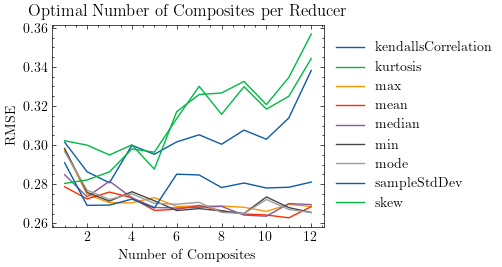

In [5]:
# Draw the RMSEs for each reducer across the number of composites per year
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scienceplots

plt.style.use("science")

df = pd.read_csv("../reports/compositing.csv")

ax = plt.subplot()
for name, group in df.groupby("Reducer"):
    group.plot(x="Composites", y="Root Mean Squared Error", ax=ax, label=name)

# Format
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Optimal Number of Composites per Reducer")
ax.set_xlabel("Number of Composites")
ax.set_ylabel("RMSE")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

figure_path = f"../reports/figures/compositing/{ax.get_title()}.svg"
Path(figure_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figure_path, dpi=300)

# Result

The optimal number of composites for each compositing method differs significantly. In above figure, the RMSEs for each compositing method are shown. For example `kurtosis` and `skew` both have their optimum at a low composite count, while `mean` and `median` tend to perform better with a higher number of composites. The optimal number of composites for each compositing method is as follows:

In [6]:
# Find the best number of composites for each reducer
best_combinations = df.loc[df.groupby("Reducer")["Root Mean Squared Error"].idxmin()]

best_composites = pd.DataFrame(
    data=best_combinations["Composites"].values,
    index=list(best_combinations["Reducer"]),
    columns=["Best Number of Composites"],
)

best_composites

,Best Number of Composites
kendallsCorrelation,3
kurtosis,5
max,10
mean,11
median,10
min,9
mode,9
sampleStdDev,5
skew,1


We use these optimal numbers of composites to create the final data raster used for hyperparameter tuning in the next experiment. Any empty composite or composite pixels will be filled with circular linear interpolation:

In [7]:
from ltm.features import save_raster

total_data_path = "../data/processed/data.tif"

if not Path(total_data_path).exists():
    total_data = pd.DataFrame()

    for reducer in tqdm(best_composites.index):
        num_composites = best_composites.loc[reducer, "Best Number of Composites"]
        data_path = f"../data/processed/compositing/data_{reducer}_{num_composites}.tif"
        Path(data_path).parent.mkdir(parents=True, exist_ok=True)

        if not Path(data_path).exists():
            sentinel_composite(
                target_path_from=target_path,
                data_path_to=data_path,
                time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
                temporal_reducers=[reducer],
                num_composites=int(num_composites),
                indices=indices,
                sentinel_bands=sentinel_bands,
            )

        data = load_raster(data_path)
        data = interpolate_data(data)
        data = to_float32(data)
        total_data = pd.concat([total_data, data], axis=1)

    save_raster(total_data, "../data/processed/target.tif", total_data_path)

print("Done")

Done
